# Topic Modeling: probabilistic LSA / Non-negative Matrix Factorization

Probabilistic Latent Semantic Analysis (pLSA) takes a statistical perspective on LSA and creates a generative model to address the lack of theoretical underpinnings of LSA. 

pLSA explicitly models the probability each co-occurrence of documents d and words w described by the DTM as a mixture of conditionally independent multinomial distributions that involve topics t. 
The symmetric formulation of this generative process of word-document co-occurrences assumes both words and documents are generated by the latent topic class, whereas the asymmetric model assumes the topics are selected given the document, and words result in a second step given the topic.
$$P(w, d) = \underbrace{\sum_tP(d\mid t)P(w\mid t)}_{\text{symmetric}}=\underbrace{P(d) \sum_tP(t\mid d)P(w\mid t)}_{\text{asymmetric}}$$
The number of topics is a hyperparameter chosen prior to training and is not learned from the data. 


The benefits of using a probability model is that we can now compare models by evaluating the probability they assign to new documents given the parameters learned during training.

## Imports & Settings

In [3]:
import warnings
from collections import OrderedDict
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [5]:
# change to your data path if necessary
DATA_DIR = Path('../data')

In [6]:
path = DATA_DIR / 'bbc'
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [7]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
Category    2225 non-null object
Heading     2225 non-null object
Article     2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

In [8]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.Category, 
                                         test_size=50, 
                                         random_state=42)

In [9]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [10]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Politics          9
Entertainment     9
Tech              9
Name: Category, dtype: int64

### Vectorize train & test sets

In [11]:
vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.Article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 204945 stored elements in Compressed Sparse Row format>

In [12]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 4759 stored elements in Compressed Sparse Row format>

### Get token counts

In [13]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film       41.54
game       36.39
best       36.15
labour     33.14
music      31.20
company    29.99
election   28.59
england    28.36
party      28.06
market     27.51
dtype: float64

## probabilistic Latent Semantic Analysis

### Implementation using Non-Negative Matrix Factorization

pLSI [has been shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.8839&rep=rep1&type=pdf) to be equivalent to Non-Negative Matrix Factorization with Kullback-Leibler Divergence objective.

pLSI is equivalent to Non-Negative Matrix Factorization using a Kullback-Leibler Divergence objective (see references on GitHub). Hence, we can use the [sklearn.decomposition.NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) class to implement this model, following closely the LSA example.

In [14]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

Using the same train-test split of the DTM produced by the TfidfVectorizer, we fit pLSA like so:

In [15]:
nmf = NMF(n_components=n_components, 
          random_state=42, 
          solver='mu',
          beta_loss='kullback-leibler', 
          max_iter=1000)
nmf.fit(train_dtm)

NMF(alpha=0.0, beta_loss='kullback-leibler', init=None, l1_ratio=0.0,
  max_iter=1000, n_components=5, random_state=42, shuffle=False,
  solver='mu', tol=0.0001, verbose=0)

We get a measure of the reconstruction error that is a substitute for the explained variance measure for LSI:

In [16]:
nmf.reconstruction_err_

316.2609400385988

### Explore Topics

In [19]:
train_doc_topics = nmf.transform(train_dtm)
train_doc_topics.shape

(2175, 5)

In [20]:
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], 
                                         index=topic_labels)))

Category                             Business
Heading     Tokyo says deflation 'controlled'
Topic 1                                  0.02
Topic 2                                  0.01
Topic 3                                  0.08
Topic 4                                  0.00
Topic 5                                  0.00
dtype: object

In [21]:
train_result = pd.DataFrame(data=train_doc_topics,
                   columns=topic_labels,
                   index=train_docs.Category)

In [22]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.Category)

Due to its probabilistic nature, pLSA produces only positive topic weights that result in more straightforward topic-category relationships for the test and training sets:

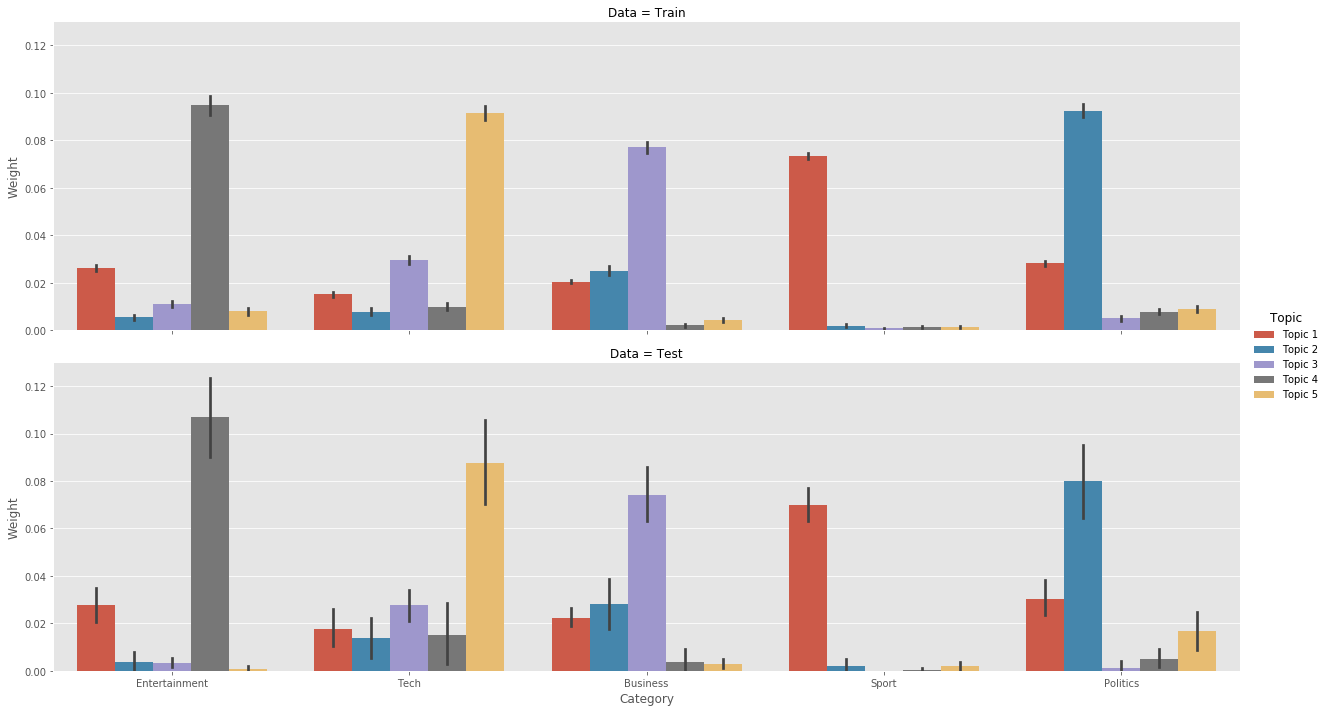

In [23]:
result = pd.melt(train_result.assign(Data='Train')
                 .append(test_eval.assign(Data='Test'))
                 .reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

result = pd.melt(train_result.assign(Data='Train')
                 .append(test_eval.assign(Data='Test'))
                 .reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

g =sns.catplot(x='Category', y='Weight', hue='Topic', row='Data', kind='bar', data=result, aspect=3.5)

### Most important words by topic

We can also see that the word lists that describe each topic begin to make more sense, e.g. the ‘Entertainment’ category is most directly associated with Topic 4 that includes the words ‘film’, ‘start’, etc.

In [25]:
topics = pd.DataFrame(nmf.components_.T,
                      index=tokens,
                      columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.00,0.00,0.01,0.41,0.00
game,0.35,0.00,0.00,0.00,0.02
best,0.27,0.00,0.00,0.25,0.00
labour,0.00,0.31,0.00,0.01,0.00
music,0.00,0.00,0.00,0.24,0.19
company,0.04,0.00,0.51,0.00,0.00
election,0.00,0.31,0.00,0.00,0.00
england,0.24,0.00,0.00,0.00,0.00
party,0.01,0.32,0.00,0.03,0.01
market,0.01,0.03,0.46,0.00,0.00


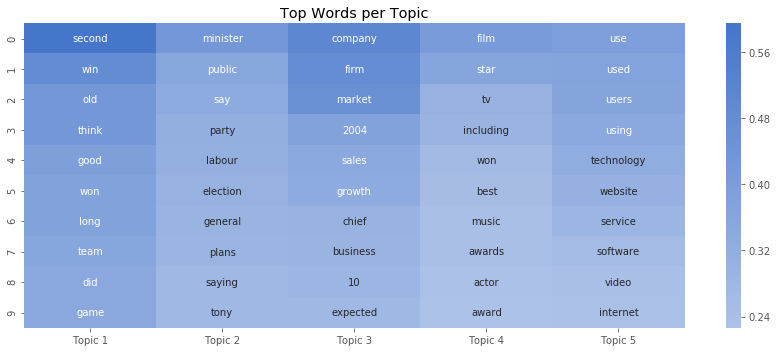

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals), 
            annot=top_words, 
            fmt = '', 
            center=0, 
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), 
            ax=ax);
ax.set_title('Top Words per Topic')
fig.tight_layout();

In [63]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.26,0.00,0.29,0.00,0.00
100,0.04,0.06,0.06,0.00,0.09
100m,0.04,0.00,0.00,0.00,0.00
11,0.08,0.00,0.10,0.11,0.00
12,0.13,0.00,0.17,0.00,0.00


In [64]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,second,minister,company,film,use
1,win,public,firm,star,used
2,old,say,market,tv,users
3,think,party,2004,including,using
4,good,labour,sales,won,technology
5,won,election,growth,best,website
6,long,general,chief,music,service
7,team,plans,business,awards,software
8,did,saying,10,actor,video
9,game,tony,expected,award,internet
